In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from datetime import datetime
from pathlib import Path
import pickle
import sys

from pymatgen.core.structure import Molecule

In [3]:
# All plotting and whatnot
import matplotlib as mpl
import matplotlib.pyplot as plt

# I prefer these defaults
default_DPI = 250
labelsize = 12
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

Append the `home` path of this project.

In [4]:
sys.path.append(str(Path.cwd().parent))

# Principal component analysis: verifying the data

In this notebook, we perform basic analysis and Principal Component Analysis to validate that our dataset look sensible.

In [5]:
from sklearn.decomposition import PCA

Load in the previously processed `pickle` data. These contain the features (ACSF) and targets (spectra) on a common grid for each of the three absorbing atom types of interest: C, N and O.

In [6]:
O_data = pickle.load(open("../data/qm9/XANES-220622-ACSF-O.pkl", "rb"))
N_data = pickle.load(open("../data/qm9/XANES-220622-ACSF-N.pkl", "rb"))
C_data = pickle.load(open("../data/qm9/XANES-220622-ACSF-C.pkl", "rb"))

Print some diagonstics...

In [7]:
print(f"O database ACSF & spectrum shapes: {O_data['x'].shape} & {O_data['y'].shape}")
print(f"N database ACSF & spectrum shapes: {N_data['x'].shape} & {N_data['y'].shape}")
print(f"C database ACSF & spectrum shapes: {C_data['x'].shape} & {C_data['y'].shape}")

O database ACSF & spectrum shapes: (186813, 155) & (186813, 200)
N database ACSF & spectrum shapes: (139058, 155) & (139058, 200)
C database ACSF & spectrum shapes: (841912, 155) & (841912, 200)


Put everything in a dictionary for simplicity.

In [8]:
data = {"O": O_data, "N": N_data, "C": C_data}

## Execute and plot

In [9]:
pca_results = dict()
for key, dat in data.items():
    pca_acsf = PCA(2)
    w_acsf = pca_acsf.fit_transform(dat["x"])
    pca_spectra = PCA(2)
    w_spectra = pca_spectra.fit_transform(dat["y"])
    pca_results[key] = {
        "pca_ACSF": pca_acsf,
        "pca_spectra": pca_spectra,
        "w_ACSF": w_acsf,
        "w_spectra": w_spectra
    }

In [10]:
pca_results.keys()

dict_keys(['O', 'N', 'C'])

In [11]:
for key, dat in pca_results.items():
    pca_ACSF = dat["pca_ACSF"]
    pca_spectra = dat["pca_spectra"]
    print(f"Key={key}, ACSF var ratios={pca_ACSF.explained_variance_ratio_}, spectra var ratios={pca_spectra.explained_variance_ratio_}")

Key=O, ACSF var ratios=[0.77001986 0.10912817], spectra var ratios=[0.60050381 0.21521107]
Key=N, ACSF var ratios=[0.74167122 0.0895742 ], spectra var ratios=[0.41484584 0.25633509]
Key=C, ACSF var ratios=[0.61404781 0.15616866], spectra var ratios=[0.34132816 0.28826326]


We make a production-quality plot of the data here:

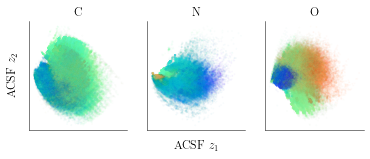

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2))

N = None
key_ordering = ["C", "N", "O"]

for key, ax in zip(key_ordering, axs):
    w_acsf = pca_results[key]["w_ACSF"]
    w_spectra = pca_results[key]["w_spectra"]
    ax.scatter(w_acsf[:N, 0], w_acsf[:N, 1], alpha=0.02, c=w_spectra[:N, 0], s=1, cmap="rainbow", rasterized=True)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(key)

axs[0].set_ylabel(r"ACSF $z_2$")
axs[1].set_xlabel(r"ACSF $z_1$")
    
# plt.savefig("qm9_pca.svg", bbox_inches="tight", dpi=300)
plt.show()

# Train/validation-test split

In [13]:
from xas_nne.qm9 import random_split, split_qm9_data_by_number_of_absorbers, remove_zwitter_ions_

## Random split

In [14]:
for CENTRAL_ATOM in ["C", "N", "O"]:
    print(f"{CENTRAL_ATOM} original length {len(data[CENTRAL_ATOM]['x'])}")
    remove_zwitter_ions_(data[CENTRAL_ATOM])

C original length 841912
Down-sampled to 833467 data after removing zwitter ions
N original length 139058
Down-sampled to 135860 data after removing zwitter ions
O original length 186813
Down-sampled to 183497 data after removing zwitter ions


In [15]:
for CENTRAL_ATOM in ["C", "N", "O"]:
    prop = 0.1 if CENTRAL_ATOM != "C" else 0.05
    parsed_data = random_split(data[CENTRAL_ATOM], prop_test=prop, prop_val=prop)
    now = datetime.now().strftime("%y%m%d")
    fname = f"../data/qm9/ml_ready/XANES-{now}-ACSF-{CENTRAL_ATOM}-RANDOM-SPLITS.pkl"
    print(fname)
    pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)

Done with 750121 train, 41673 val and 41673 test
../data/qm9/ml_ready/XANES-220710-ACSF-C-RANDOM-SPLITS.pkl
Done with 108688 train, 13586 val and 13586 test
../data/qm9/ml_ready/XANES-220710-ACSF-N-RANDOM-SPLITS.pkl
Done with 146799 train, 18349 val and 18349 test
../data/qm9/ml_ready/XANES-220710-ACSF-O-RANDOM-SPLITS.pkl


## Train on molecules with at most `N` absorbers

In [19]:
# for CENTRAL_ATOM, max_training_absorbers in zip(["C", "N", "O"], [7, 4, 3]):
#     parsed_data = split_qm9_data_by_number_of_absorbers(data[CENTRAL_ATOM], absorber=CENTRAL_ATOM, max_training_absorbers=max_training_absorbers)
#     parsed_data["metadata"] = {"max_training_absorbers": max_training_absorbers}
#     now = datetime.now().strftime("%y%m%d")
#     fname = f"../data/qm9/ml_ready/XANES-{now}-ACSF-{CENTRAL_ATOM}-MAX_TRAINING_ABSORBERS-{max_training_absorbers}.pkl"
#     print(fname)
#     pickle.dump(parsed_data, open(fname, "wb"), protocol=pickle.HIGHEST_PROTOCOL)